In [1]:
import torch
import tokenizers
import llm
import os
import sae
import tqdm
import json



# expt_name = 'e2e_sae_1'
expt_name = 'vanilla_split_llm_sae'
expt_dir = f'experiments/{expt_name}'

def loadconfig():
    global config
    config = json.load(open(f"experiments/{expt_name}/config.json"))
    for k,v in config.items():
        globals()[k] = v

loadconfig()



In [2]:
data = torch.load('tiny-stories-train.pt', map_location='cuda')
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]


In [3]:
def get_batch_by_index(split, ix):
    data = train_data if split == 'train' else val_data
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y

In [4]:
idxs = torch.load(f'{expt_dir}/encoded/test_accum_idxs.pt')
values = torch.load(f'{expt_dir}/encoded/test_accum_values.pt')

In [21]:
val_data = val_data[:len(idxs)]
top_feat_idx = idxs[:, 0]
top_feat_values = values[:, 0]
top_feat_idx[0]


tensor(12803, device='cuda:0')

In [24]:
top_feat_idx[200]

tensor(12803, device='cuda:0')

In [6]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    "./tiny-stories-bpe-vocab.json", 
    "./tiny-stories-bpe-merges.txt"
)
def encode(text):
    return tokenizer.encode(text).ids
def decode(encoded_text):
    return tokenizer.decode(encoded_text)

def get_text_from_global_index(token_idx, context_size=10):
    token = val_data[token_idx].item()
    lower_bound = max(0, token_idx-context_size)
    upper_bound = min(len(val_data), token_idx+context_size)
    return decode([token]), decode(val_data[lower_bound:upper_bound].tolist())

print(get_text_from_global_index(int(24 * 1e6)))


(' small', ' had lots of green leaves. One day, a small seed fell from the tree and landed on the')


/tmp/ipykernel_5779/1713805309.py:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


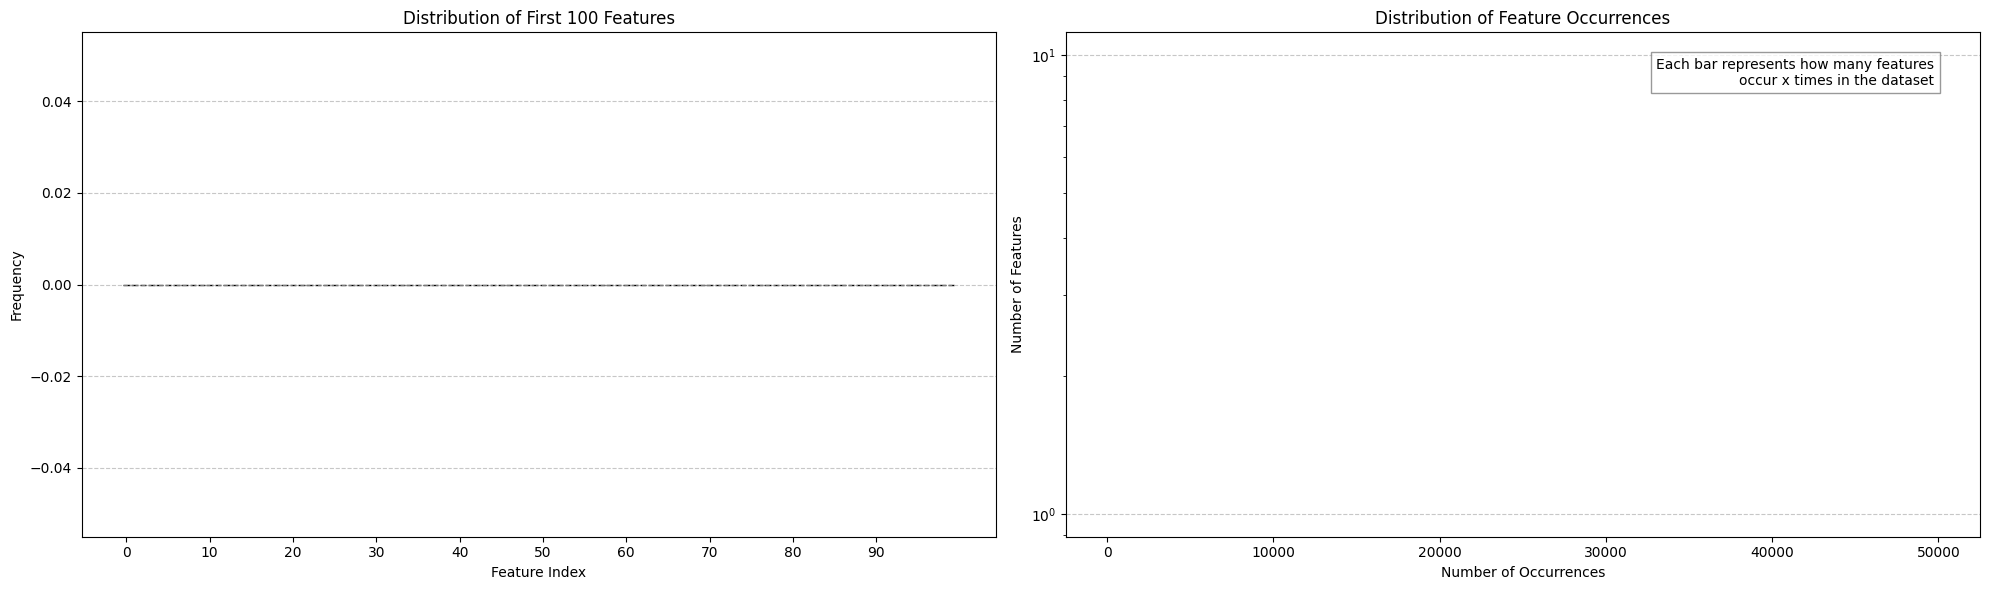

Total number of unique features: 1
Maximum number of occurrences for a single feature: 46792704
Number of features occurring only once: 0
Most common feature index: 12803
Occurrences of most common feature: 46792704


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Convert top_feat_idx to numpy array if it's not already
top_feat_idx_np = top_feat_idx.cpu().numpy()

# Create the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First plot (histogram of first 100 features)
feature_counts = Counter(top_feat_idx_np)
first_100_features = [feature_counts[i] for i in range(100)]

ax1.bar(range(100), first_100_features, edgecolor='black')
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of First 100 Features')
ax1.set_xticks(range(0, 100, 10))
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')

# Second plot (distribution of feature occurrences)
occurrence_distribution = Counter(feature_counts.values())
occurrences = list(occurrence_distribution.keys())
num_features = list(occurrence_distribution.values())

max_occurrences = min(max(occurrences), 50000)
ax2.hist(occurrences, bins=50, range=(0, max_occurrences), weights=num_features, edgecolor='black')
ax2.set_xlabel('Number of Occurrences')
ax2.set_ylabel('Number of Features')
ax2.set_title('Distribution of Feature Occurrences')
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
ax2.set_yscale('log')

# Add text to explain the second plot
ax2.text(0.95, 0.95, 'Each bar represents how many features\noccur x times in the dataset', 
         transform=ax2.transAxes, ha='right', va='top', 
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total number of unique features: {len(feature_counts)}")
print(f"Maximum number of occurrences for a single feature: {max(occurrences)}")
print(f"Number of features occurring only once: {occurrence_distribution[1]}")
print(f"Most common feature index: {max(feature_counts, key=feature_counts.get)}")
print(f"Occurrences of most common feature: {max(feature_counts.values())}")


In [20]:
feat_idx = top_feat_idx[953].item()

# get where the most common feature occurs (tok idxs)

feature_locations = torch.where(top_feat_idx == feat_idx)[0] # IDK why this is a tuple
print(f"Feature {feat_idx} occurs {len(feature_locations)} times in the dataset")
feature_values = top_feat_values[feature_locations]
# shuffle the locations
permutation = torch.randperm(len(feature_locations)).to('cpu')
feature_locations = feature_locations[permutation]
feature_values = feature_values[permutation]

Feature 12803 occurs 46792704 times in the dataset


In [16]:
for location, strength in zip(feature_locations[:30], feature_values[:30]):
    print(strength.item(), get_text_from_global_index(location.item(), context_size=5))

46.494956970214844 (' rules', " to the old man's rules. He spun them")
48.33059310913086 (' day', ' They played with it every day and had lots of')
49.1414680480957 ('Once', '\n<|endoftext|>\nOnce upon a time,')
46.15776443481445 (' feeling', '. He loved playing and feeling the sand between his')
48.3259391784668 (' ', ' okay", said dad. \nSam wanted to')
50.8036003112793 (' You', ' time for your nap. You need to rest and')
49.513370513916016 (' She', ' Anna was not happy. She did not like the')
47.198490142822266 (' those', ' limited money and those are very expensive.')
44.33064270019531 (' year', ' snowball fight.\nThis year, they decided to')
49.4360466003418 (' and', ' lady came up to her and asked what was wrong')
47.286922454833984 (' very', ' park today. He was very upset.\nThen')
46.80589294433594 (' he', "'s hair. He wished he had not requested the")
51.2578125 (' ran', ' together every day. They ran and jumped with lots')
55.38978576660156 (' mommy', ' still light outside. H